In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import glob, os

# Get images path

In [22]:
IMG_NAME = 'test1'  #원하는 이미지가 있는 폴더 이름 설정

img_list = []
for ext in ('*.gif', '*.png'):
    img_list.extend(glob.glob(os.path.join('imgs', IMG_NAME, ext))) #img_list에 이미지의 경로들을 저장

img_list = sorted(img_list)

print(img_list)

['imgs\\test1\\imgs_1.png', 'imgs\\test1\\imgs_2.png', 'imgs\\test1\\imgs_3.png', 'imgs\\test1\\imgs_4.png', 'imgs\\test1\\imgs_5.png', 'imgs\\test1\\imgs_6.png', 'imgs\\test1\\imgs_7.png', 'imgs\\test1\\imgs_8.png', 'imgs\\test1\\imgs_9.png', 'imgs\\test1\\imgs_91.png']


# Load images

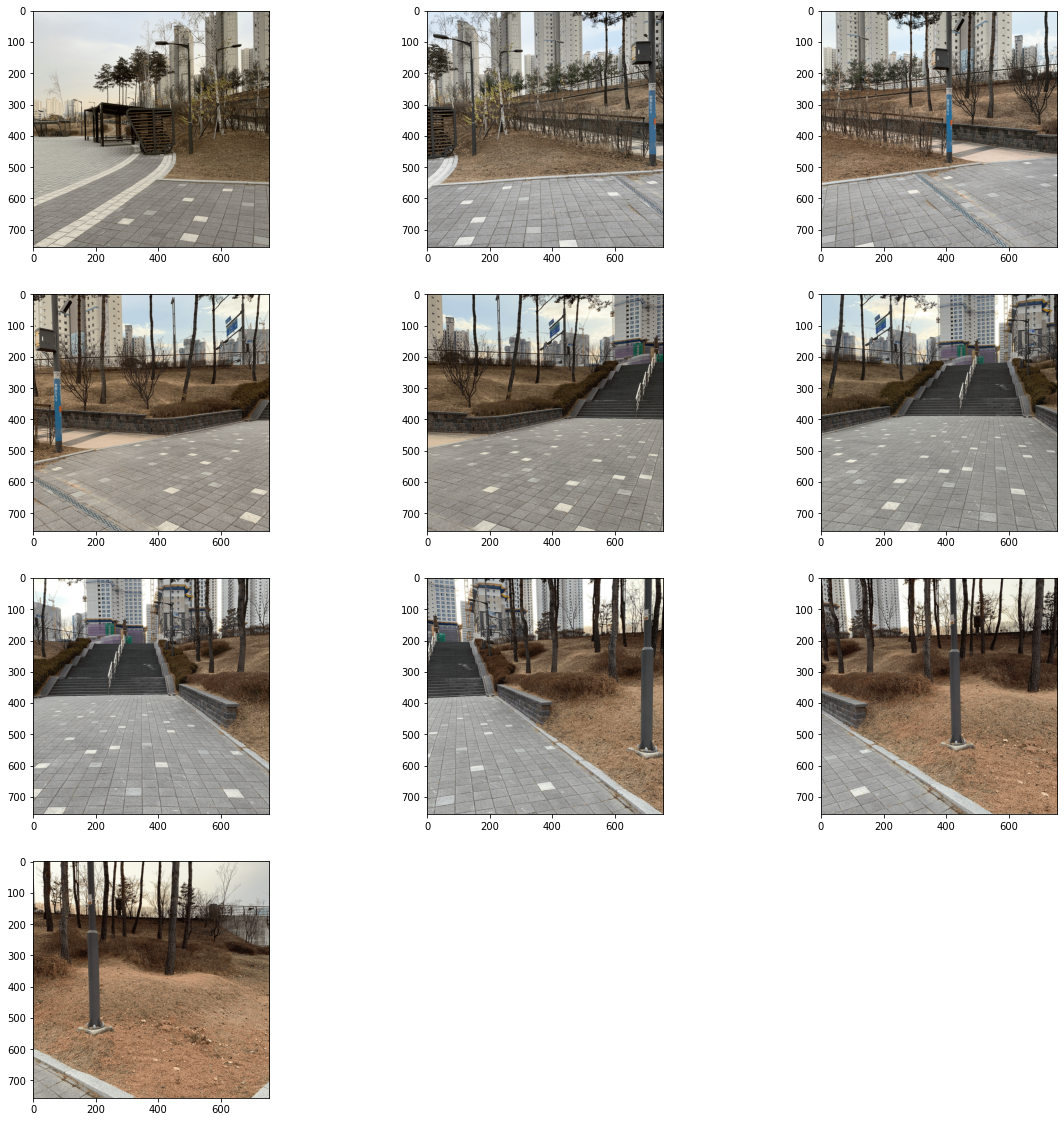

In [23]:
#불러온 이미지들을 plt로 나타내면서 하나하나 확인함
imgs = []

plt.figure(figsize=(20, 20))

for i, img_path in enumerate(img_list):
    img = cv2.imread(img_path)
    imgs.append(img)
    
    plt.subplot(len(img_list) // 3 + 1, 3, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Stitch images

img1 - 3865 features, img2 - 3861 features
img1 - 3861 features, img2 - 3817 features
img1 - 3817 features, img2 - 3418 features
img1 - 3418 features, img2 - 3040 features
img1 - 3040 features, img2 - 2806 features
img1 - 2806 features, img2 - 3095 features
img1 - 3095 features, img2 - 3971 features
img1 - 3971 features, img2 - 4290 features
img1 - 4290 features, img2 - 3214 features


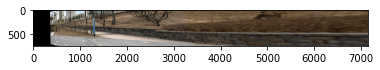

In [25]:
import numpy as np
import cv2 as cv
import imutils

#코드 시작

num = len(imgs) #9개이므로 num=9
result_exist = False #result_crop파일이 없으면 이미지를 불러온다
#img1 = imgs[num] 가장 마지막 이미지(즉, 오른쪽 이미지를 불러온다)
for i in range(1, 10):
     #img1: 오른쪽 이미지, img2: 왼쪽 이미지        
    img2 = imgs[num-i-1]
    img1 = imgs[num-i]
    
    gray1 = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    gray2 = cv.cvtColor(img2, cv.COLOR_BGR2GRAY)
    
    #detector = cv.ORB_create()  #키포인트를 찾기 위해 ORB알고리즘 사용
    detector = cv.SIFT_create() #ORB 알고리즘의 경우 많은 이미지를 stitching했을 때 테두리 제거 부분에서 에러발생

    #keypoint: 이미지에서 검출한 특징
    #회전, 이동, 크기변화 등에도 항상 검출되는 물체의 특정 지점이어야 함
    
    keyPoints1, descriptors1 = detector.detectAndCompute(gray1, None)
    #검출된 특징의 좌표, 두 키포인트 유사도 계산에 사용되는 정보 저장
    keyPoints2, descriptors2 = detector.detectAndCompute(gray2, None)
    print('img1 - %d features, img2 - %d features' % (len(keyPoints1), len(keyPoints2)))
    
    bf=cv.BFMatcher()
    matches = bf.match(descriptors1, descriptors2)
    
    sorted_matches=sorted(matches, key=lambda x: x.distance)
    #img_matching_result = cv.drawMatches(img1, keyPoints1, img2, keyPoints2, sorted_matches[:30], None, flags=2)
    
    src = np.float32([keyPoints1[m.queryIdx].pt for m in matches]).reshape((-1, 1, 2))
    dst = np.float32([keyPoints2[m.trainIdx].pt for m in matches]).reshape((-1, 1, 2))
    H, status = cv.findHomography(src, dst, cv.RANSAC, 5.0)
    
    # warpPerspective: 원근 뒤틀기
    # for문이 1번 돌고난 후 result image가 생성되었으면 그 result 이미지를 warp하여 스티칭한다
    # for문이 한번도 돌지 않았으면 오른쪽 이미지를 warp하여 왼쪽 이미지와 스티칭
    if result_exist:
        warped = cv.warpPerspective(res_img, H, (img1.shape[1]+res_img.shape[1], img1.shape[0]))
        r,c = warped.shape[:2]
        plt.imshow(cv.cvtColor(warped, cv.COLOR_BGR2RGB))
    else:
        warped = cv.warpPerspective(img1, H, (img1.shape[1]+img2.shape[1], img1.shape[0]))


    #두 이미지가 연결도록 함
    result = np.copy(warped)
    M, N = img2.shape[:2]
    result[0:M, 0:N, :] = img2
    
    
    #가장자리 부분 제거
    #stitched = cv.copyMakeBorder(result, 10, 10, 10, 10, cv2.BORDER_CONSTANT, (0, 0, 0))
    gray = cv.cvtColor(result, cv.COLOR_BGR2GRAY)
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY)[1] 
    cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 
    cnts = imutils.grab_contours(cnts) 
    c = max(cnts, key=cv.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8") 
    (x, y, w, h) = cv.boundingRect(c) 
    cv.rectangle(mask, (x, y), (x + w, y + h), 255, -1)
    minRect = mask.copy()
    sub = mask.copy()
    while cv.countNonZero(sub) > 0: 
        minRect = cv.erode(minRect, None)
        sub = cv.subtract(minRect, thresh) 
    cnts = cv.findContours(minRect.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) 
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv.contourArea)
    (x, y, w, h) = cv.boundingRect(c)
    #적절한 가장자리 좌표를 찾아 크롭
    stitched = result[y:y+h, x:x + w]

    #크롭된 stitched image를 result.png파일로 내보냄
    cv.imwrite('result.png', stitched)
    
    # 다음 for문을 실행하기 위해 res_img에 결과 이미지를 미리 불러옴
    res_img=cv.imread('result.png')
    result_exist=True